In [28]:
import numpy as np
from scipy.sparse import hstack, issparse
import scipy.linalg as sla
from scipy.sparse.linalg import expm
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score
from scipy.optimize.linesearch import scalar_search_wolfe2
from scipy.optimize import brent, golden
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import time
import scipy
from collections import deque

import warnings
warnings.filterwarnings("ignore")

$$
\begin{gathered}
loss(w) = - \frac{1}{N} (y * \log(\sigma(X w^T)) + (1 - y) * \log (\sigma (X w^T)) \\
\nabla loss(w) = \frac{1}{N} X^T * (\sigma(w^T X) - y) \\
\nabla^2 loss(w) = X (\sigma(w^T X)(1 - \sigma(w^T X))) X^T
\end{gathered}
$$

## Оракул

In [29]:
class Oracle:

    def __init__(self, X, y):
        self.X = self.__extend_X(X)
        self.y = y
        self.__n_calls = 0
        self.eps = 1e-08
        self.N = self.y.shape[0]

    
    def start_count(self, W_init):
        self.__opt_score = self.__get_optimum_score(W_init)
        self.__init_grad = self.grad(W_init)
        self.__n_calls = 0
        self.__n_iter = 0
        self.__time = time.time()

        self.iter_array = []
        self.time_array = []
        self.calls_array = []
        self.scores_1 = []
        self.scores_2 = []
        self.entropy = []

    
    def __get_optimum_score(self, W_init):
        result = scipy.optimize.minimize(self.value, x0 = W_init, method='Newton-CG', 
                             jac=self.grad, hess=self.hessian)
        return self.value(result.x)


    def next_iteration(self, x):
        self.iter_array.append(self.__n_iter)
        self.calls_array.append(self.__n_calls)

        self.time_array.append(time.time() - self.__time)
        self.__n_iter += 1
        entropy = self.value(x) 

        score_1 = abs(entropy - self.__opt_score)
        score_2 = np.linalg.norm(self.grad(x)) ** 2 / np.linalg.norm(self.__init_grad) ** 2 
        self.scores_1.append(score_1)
        self.scores_2.append(score_2)
        self.entropy.append(entropy)


    def get_n_calls(self):
        return self.__n_calls


    def __extend_X(self, X):
        intercept = np.ones((X.shape[0], 1))
        if issparse(X):
            return hstack([intercept, X])
        else:
            return np.hstack([intercept, X])


    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


    def get_prob(self, w):
        p = self.__sigmoid(self.X @ w.T)
        return np.clip(p, 1e-10, 1 - 1e-10)


    def value(self, w):
        p = self.get_prob(w)
        self.__n_calls += 1

        return -(self.y * np.log(p + self.eps) + (1 - self.y) * np.log(1 - p + self.eps)).mean()


    def grad(self, w):
        p = self.get_prob(w)
        self.__n_calls += 1

        return self.X.T @ (p - self.y) / self.N

    def hessian(self, w):
        p = self.get_prob(w)
        self.__n_calls += 1

        return self.X.T @ np.diag(p * (1 - p)) @ self.X / self.N

    def hessian_vec_product(self, w, d):
        p = self.get_prob(w)
        self.__n_calls += 1
        result = (self.X @ d)
        result = np.diag(p * (1 - p)) @ result
        result = self.X.T @ result

        return result / self.N


    def fuse_value_grad(self, x):
        return self.value(x), self.grad(x)


    def fuse_value_grad_hessian(self, x):
        return self.value(x), self.grad(x), self.hessian(x)


    def fuse_value_grad_hessian_vec_product(self, x, d):
        return self.value(x), self.grad(x), self.hessian_vec_product(x, d)

## Загрузка датасетов

In [30]:
def make_oracle(data_path) :
    if not data_path == 'random':
        X, y = load_svmlight_file(data_path)
        
        nums = list(set(y))
        for i in range(len(nums)):
            y[y == nums[i]] = i

        print('Dataset shape: ', X.shape, y.shape)        

        return Oracle(X, y)
     
    a, b = np.random.uniform(-1, 1, 2)
    X = (a * np.random.normal(0, 1, 1000) + b)
    y = np.apply_along_axis(lambda  x: (x >= 0).astype(np.int), 0, X)
    X = X.reshape(-1, 1)
    print('Dataset shape: ', X.shape, y.shape)
    print('Unique:', np.unique(y))

    return Oracle(X, y)

## Реализация Line Search

In [31]:
class LineSearch:

    def __init__(self, oracle, name = 'wolfe', 
                 c_armijo = 0.4, c1_wolfe=0.4, c2_wolfe=0.9):
        self.c_armijo = c_armijo
        self.c1_wolfe = c1_wolfe
        self.c2_wolfe = c2_wolfe
        self.oracle = oracle
        self.__method = name

    
    def line_search(self, x, direction, a_start=100):
        value = lambda a: self.oracle.value(x + a * direction)
        grad = lambda a: self.oracle.grad(x + a * direction).T @ direction
        
        if self.__method == 'armijo':
            return self.__armijo(value, grad, a_start)
        elif self.__method == 'wolfe':
            result = scalar_search_wolfe2(value, grad,
                                          phi0=a_start, 
                                          c1=self.c1_wolfe, c2=self.c2_wolfe)[0]

            if result is None:
                return self.__armijo(value, grad, a_start)
            return result
        elif self.__method == 'brent':
            return brent(value)
        elif self.__method == 'golden':
            return golden(value)
        elif self.__method == 'nesterov':
            return self.__nesterov(x, direction)


    def __armijo(self, value, grad, a_start, maxiter=100):
        a = a_start
        c = self.c_armijo

        for i in range(maxiter):
            if value(a) <= value(0) + c * a * grad(0):
                break

            a = a / 2

        return a

    
    def __nesterov(self, x, direction, maxiter=1000):
        L = 0.01

        for i in range(maxiter):
            x_next = x + 1 / L * direction

            if self.oracle.value(x_next) <= self.oracle.value(x) + \
                    self.oracle.grad(x).T @ (x_next - x) + \
                    L / 2 * np.linalg.norm(x_next - x) ** 2:
                break

            L = L * 2

        L = L / 2
        return 1 / L

## Начальное значение

In [32]:
def init_weights(shape, start_type='zeros'):
    if start_type == 'zeros':
        return np.zeros(shape)
    if start_type == 'ones':
        return np.ones(shape)
    if start_type == 'random':
        return np.random.uniform(0, 1, shape)

## Анализ методов

In [33]:
def analyze(data_path, opt_method, start_type='zeros', nesterov=True, graph=True):
    oracle = make_oracle(data_path)
    start_point = init_weights(oracle.X.shape[1], start_type)

    line_search_methods = ['golden', 'wolfe', 'brent', 'armijo']
    if nesterov:
        line_search_methods.append('nesterov')

    dict_time = {}
    dict_iters = {}
    dict_calls = {}
    dict_scores_1 = {}
    dict_scores_2 = {}
    dict_entropy = {}

    for line_search in tqdm(line_search_methods):
        ls = LineSearch(oracle, line_search)
        _ = opt_method(oracle, start_point, ls)

        dict_time[line_search] = oracle.time_array
        dict_iters[line_search] = oracle.iter_array
        dict_calls[line_search] = oracle.calls_array
        dict_scores_1[line_search] = oracle.scores_1
        dict_scores_2[line_search] = oracle.scores_2
        dict_entropy[line_search] = oracle.entropy

    table = []
    for line_search in line_search_methods:
        row = {}
        row['Method'] = line_search
        row['Entropy'] = dict_entropy[line_search][-1]
        row['Num Iter'] = dict_iters[line_search][-1]
        row['Oracle Calls'] = dict_calls[line_search][-1]
        row['Time'] = int(dict_time[line_search][-1] * 100) / 100
        table.append(row)

    print(tabulate(table, headers="keys", tablefmt="github"))

    if graph:
        for line_dict, name in [(dict_time, 'Time'), (dict_iters, 'Iterations'), (dict_calls, 'Calls')]:
            _, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,4))

            for line_search in line_search_methods:
                axes[0].plot(line_dict[line_search], np.log(dict_scores_1[line_search]), label=line_search);
                axes[1].plot(line_dict[line_search], np.log(dict_scores_2[line_search]), label=line_search);

            axes[0].legend()
            axes[0].set_xlabel(name)
            axes[0].set_ylabel('log|F(w) - F(w*)|')
            axes[1].legend()
            axes[1].set_xlabel(name)
            axes[1].set_ylabel('log(|grad F(w)|^2 / |grad F(w_0)|^2)')

            plt.suptitle(name)
            plt.show()

## Градиентный спуск

In [34]:
def optimize(f, start_point, line_search, tol=1e-08, max_iter=10000):

    W_init = start_point
    W_init_grad = f.grad(W_init)

    W = W_init.copy()
    W_grad = W_init_grad.copy()

    f.start_count(W_init)

    for k in range(max_iter + 1):
        if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < tol:
            break

        direction = -W_grad
        a = line_search.line_search(W, direction)
        W += a * direction

        W_loss, W_grad = f.fuse_value_grad(W)

        f.next_iteration(W)

    return W

## Метод Ньютона

In [35]:
def cholesky(A, b, tol):
    A_k = A.copy()
    is_fine = False
    tk = tol

    while not is_fine:
        try:
            L = np.linalg.cholesky(A_k)

            is_fine = True
        except np.linalg.LinAlgError:
            is_fine = False
        
        A_k = A_k + np.eye(A_k.shape[0]) * tk
        tk *= 2

    y = sla.solve(L, b)
    x = sla.solve(L.T.conj(), y)

    return x

In [36]:
def optimize_newton(f, start_point, line_search, tol=1e-08, max_iter=10000):

    W_init = start_point
    W_init_grad = f.grad(W_init)

    W = W_init.copy()

    f.start_count(W_init)
    
    W_grad = f.grad(W)
    W_hessian = f.hessian(W)

    for k in range(max_iter + 1):
        if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < tol:
            break

        direction = cholesky(W_hessian, -W_grad, tol)
        direction_norm = np.linalg.norm(direction)

        if direction_norm > 1000:
            direction = direction / direction_norm

        a = line_search.line_search(W, direction, 1)
        W += a * direction

        W_loss, W_grad, W_hessian = f.fuse_value_grad_hessian(W)
        
        f.next_iteration(W)

    return W

## Hessian-Free Newton

In [37]:
def conj_grad(oracle, W, W_grad, tol, start_point):
    x = start_point
    g = oracle.hessian_vec_product(W, x) + W_grad
    d = -g
    stopping_crit = tol * np.linalg.norm(W_grad)
    g_norm = g.T @ g

    n = len(W)

    for i in range(2 * n):
        if np.linalg.norm(g) <= stopping_crit:
            break
            
        prod = oracle.hessian_vec_product(W, d)
        alpha = g_norm / (d @ prod)
        x += alpha * d
        g += alpha * prod

        g_norm_2 = g.T @ g
        beta = g_norm_2 / g_norm
        d = beta * d - g
        g_norm = g_norm_2

    return x

In [38]:
def hfn_optimize(f, start_point, line_search, tol=1e-08, max_iter=10000):

    W_init = start_point
    W_init_grad = f.grad(W_init)

    W = W_init.copy()
    W_grad = W_init_grad.copy()

    f.start_count(W_init)

    for k in range(max_iter + 1):
        
        if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < tol:
            break

        tol_eta = min(0.5, np.sqrt(np.linalg.norm(W_grad)))
        direction = conj_grad(f, W, W_grad, tol_eta, -W_grad)

        while direction.T @ W_grad >= 0:
            tol_eta /= 10
            direction = conj_grad(f, W, W_grad, tol_eta, direction)

        a = line_search.line_search(W, direction, 1)
        W += a * direction

        W_loss, W_grad = f.fuse_value_grad(W)

        f.next_iteration(W)


    return W

# L-BFGS

In [39]:
def count_bfgs_direction(H, W_grad):
    d = -W_grad

    if len(H) > 0:
        mu = np.zeros(len(H))
        for i in range(len(H) - 1, -1, -1):
            s, y = H[i]
            mu[i] = (s.T @ d) / (s.T @ y)
            d -= mu[i] * y

      
        s, y = H[-1]
        d = (s.T @ y) / (y.T @ y) * d

        for i in range(0, len(H)):
            s, y = H[i]
            b = (y @ d) / (s.T @ y)
            d += (mu[i] - b) * s

    return d

In [40]:
def lbfgs_optimize(f, start_point, tol=1e-08, max_iter=10000, l=100):

    W_init = start_point
    W_init_grad = f.grad(W_init)

    line_search = LineSearch(f, 'wolfe')

    W = W_init.copy()
    W_grad = W_init_grad.copy()

    W_priv, W_grad_priv = W, W_grad
    
    H = deque([]) 

    f.start_count(W_init)

    for k in range(max_iter + 1):
        if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < tol:
            break

        direction = count_bfgs_direction(H, W_grad)
        a = line_search.line_search(W, direction)

        W_priv, W_grad_priv = W.copy(), W_grad.copy()

        W += a * direction
        W_loss, W_grad = f.fuse_value_grad(W)
  
        f.next_iteration(W)

        H.append((W - W_priv, W_grad - W_grad_priv))
        if len(H) > l:
            H.popleft()

    return W

# Анализ L-BFGS

In [41]:
def analyze_bfgs(data_path, start_type='zeros', graph=True, ls=np.arange(10, 100, 10)):
    oracle = make_oracle(data_path)
    start_point = init_weights(oracle.X.shape[1], start_type)

    dict_time = {}
    dict_iters = {}
    dict_calls = {}
    dict_scores_1 = {}
    dict_scores_2 = {}
    dict_entropy = {}

    for l in tqdm(ls):
        _ = lbfgs_optimize(oracle, start_point, l=l)

        dict_time[l] = oracle.time_array
        dict_iters[l] = oracle.iter_array
        dict_calls[l] = oracle.calls_array
        dict_scores_1[l] = oracle.scores_1
        dict_scores_2[l] = oracle.scores_2
        dict_entropy[l] = oracle.entropy

    table = []
    for l in ls:
        row = {}
        row['History Size'] = l
        row['Entropy'] = dict_entropy[l][-1]
        row['Num Iter'] = dict_iters[l][-1]
        row['Oracle Calls'] = dict_calls[l][-1]
        row['Time'] = int(dict_time[l][-1] * 100) / 100
        table.append(row)

    print(tabulate(table, headers="keys", tablefmt="github"))

    if graph:
        for line_dict, name in [(dict_time, 'Time'), (dict_iters, 'Iterations'), (dict_calls, 'Calls')]:
            _, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,4))

            for l in ls:
                axes[0].plot(line_dict[l], np.log(dict_scores_1[l]), label=l);
                axes[1].plot(line_dict[l], np.log(dict_scores_2[l]), label=l);

            axes[0].legend()
            axes[0].set_xlabel(name)
            axes[0].set_ylabel('log|F(w) - F(w*)|')
            axes[1].legend()
            axes[1].set_xlabel(name)
            axes[1].set_ylabel('log(|grad F(w)|^2 / |grad F(w_0)|^2)')

            plt.suptitle(name)
            plt.show()

In [42]:
analyze_bfgs('a1a.txt', 'zeros', graph=False, ls=np.arange(10, 200, 10))

Dataset shape:  (1605, 119) (1605,)



|   History Size |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------------|-----------|------------|----------------|--------|
|             10 |  0.297892 |        239 |           3425 |   1.16 |
|             20 |  0.297881 |        163 |           1972 |   0.71 |
|             30 |  0.297881 |        139 |           1584 |   0.6  |
|             40 |  0.297882 |        116 |           1377 |   0.53 |
|             50 |  0.297881 |        108 |           1116 |   0.45 |
|             60 |  0.297885 |         99 |            851 |   0.37 |
|             70 |  0.297879 |         98 |            844 |   0.37 |
|             80 |  0.297881 |         90 |            742 |   0.33 |
|             90 |  0.297884 |         85 |            649 |   0.3  |
|            100 |  0.297884 |         85 |            649 |   0.3  |
|            110 |  0.297884 |         85 |            649 |   0.31 |
|            120 |  0.297884 |         85 |            649 |   0.3  |
|            130 | 

Видим, что после значения 100 не происходит улучшения на этом датасете. Проверим из другой стартовой точки.

In [43]:
analyze_bfgs('a1a.txt', 'ones', graph=False, ls=np.arange(10, 200, 10))

Dataset shape:  (1605, 119) (1605,)



|   History Size |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------------|-----------|------------|----------------|--------|
|             10 |  0.297893 |        242 |           3262 |   1.12 |
|             20 |  0.297878 |        185 |           2328 |   0.83 |
|             30 |  0.297898 |        123 |           1435 |   0.56 |
|             40 |  0.297881 |        143 |           1468 |   0.61 |
|             50 |  0.297888 |        113 |           1166 |   0.47 |
|             60 |  0.297888 |        111 |           1155 |   0.48 |
|             70 |  0.297887 |        110 |           1105 |   0.46 |
|             80 |  0.297891 |         93 |            876 |   0.4  |
|             90 |  0.297889 |         91 |            706 |   0.34 |
|            100 |  0.297889 |         91 |            706 |   0.32 |
|            110 |  0.297889 |         91 |            706 |   0.31 |
|            120 |  0.297889 |         91 |            706 |   0.32 |
|            130 | 

In [44]:
analyze_bfgs('a1a.txt', 'random', graph=False, ls=np.arange(10, 200, 10))

Dataset shape:  (1605, 119) (1605,)



|   History Size |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------------|-----------|------------|----------------|--------|
|             10 |  0.2979   |        207 |           2720 |   0.95 |
|             20 |  0.297881 |        186 |           2108 |   0.76 |
|             30 |  0.297878 |        143 |           1434 |   0.55 |
|             40 |  0.29788  |        121 |           1069 |   0.44 |
|             50 |  0.29788  |        100 |            922 |   0.39 |
|             60 |  0.297879 |         97 |            956 |   0.43 |
|             70 |  0.297878 |         95 |            737 |   0.33 |
|             80 |  0.297879 |         90 |            754 |   0.33 |
|             90 |  0.297878 |         89 |            695 |   0.32 |
|            100 |  0.297878 |         89 |            695 |   0.31 |
|            110 |  0.297878 |         89 |            695 |   0.31 |
|            120 |  0.297878 |         89 |            695 |   0.31 |
|            130 | 

Видим, что пороговое значение остановки улучшения изменяется для разной стартовой точки.

Проверим на другом датасете

In [45]:
analyze_bfgs('breast-cancer_scale.txt', 'zeros', graph=False, ls=np.arange(10, 200, 10))

Dataset shape:  (683, 10) (683,)



|   History Size |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------------|-----------|------------|----------------|--------|
|             10 | 0.0753188 |         32 |            281 |   0.05 |
|             20 | 0.0753191 |         25 |            180 |   0.04 |
|             30 | 0.075319  |         25 |            180 |   0.04 |
|             40 | 0.075319  |         25 |            180 |   0.03 |
|             50 | 0.075319  |         25 |            180 |   0.03 |
|             60 | 0.075319  |         25 |            180 |   0.04 |
|             70 | 0.075319  |         25 |            180 |   0.03 |
|             80 | 0.075319  |         25 |            180 |   0.03 |
|             90 | 0.075319  |         25 |            180 |   0.04 |
|            100 | 0.075319  |         25 |            180 |   0.03 |
|            110 | 0.075319  |         25 |            180 |   0.03 |
|            120 | 0.075319  |         25 |            180 |   0.03 |
|            130 | 

In [46]:
analyze_bfgs('random', 'zeros', graph=False, ls=np.arange(10, 200, 10))

Dataset shape:  (1000, 1) (1000,)
Unique: [0]



|   History Size |     Entropy |   Num Iter |   Oracle Calls |   Time |
|----------------|-------------|------------|----------------|--------|
|             10 | 2.81787e-05 |         13 |             96 |   0.01 |
|             20 | 2.81787e-05 |         13 |             96 |   0.01 |
|             30 | 2.81787e-05 |         13 |             96 |   0.02 |
|             40 | 2.81787e-05 |         13 |             96 |   0.01 |
|             50 | 2.81787e-05 |         13 |             96 |   0.01 |
|             60 | 2.81787e-05 |         13 |             96 |   0.01 |
|             70 | 2.81787e-05 |         13 |             96 |   0.01 |
|             80 | 2.81787e-05 |         13 |             96 |   0.01 |
|             90 | 2.81787e-05 |         13 |             96 |   0.01 |
|            100 | 2.81787e-05 |         13 |             96 |   0.02 |
|            110 | 2.81787e-05 |         13 |             96 |   0.01 |
|            120 | 2.81787e-05 |         13 |             96 | 

Есть тенденция, что значение *history_size* зависит от датасета преимущественно. Но чем больше его значение, тем быстрее сходимость и лучше результат. Поэтому надо выбирать его значение такое, чтобы оно было максимальным, но при этом алгоритм бы не выходил за рамки по значению памяти.

Dataset shape:  (1605, 119) (1605,)



|   History Size |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------------|-----------|------------|----------------|--------|
|             10 |  0.297892 |        239 |           3425 |   1.16 |
|             20 |  0.297881 |        163 |           1972 |   0.71 |
|             30 |  0.297881 |        139 |           1584 |   0.6  |
|             40 |  0.297882 |        116 |           1377 |   0.53 |
|             50 |  0.297881 |        108 |           1116 |   0.45 |
|             60 |  0.297885 |         99 |            851 |   0.37 |
|             70 |  0.297879 |         98 |            844 |   0.37 |
|             80 |  0.297881 |         90 |            742 |   0.34 |
|             90 |  0.297884 |         85 |            649 |   0.29 |


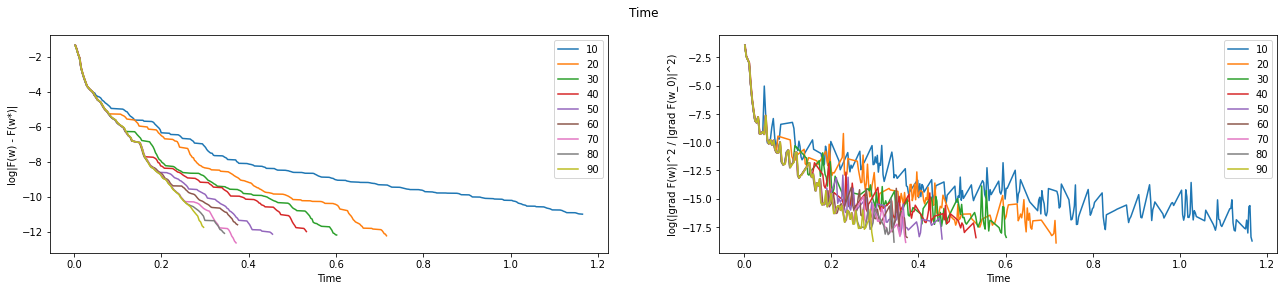

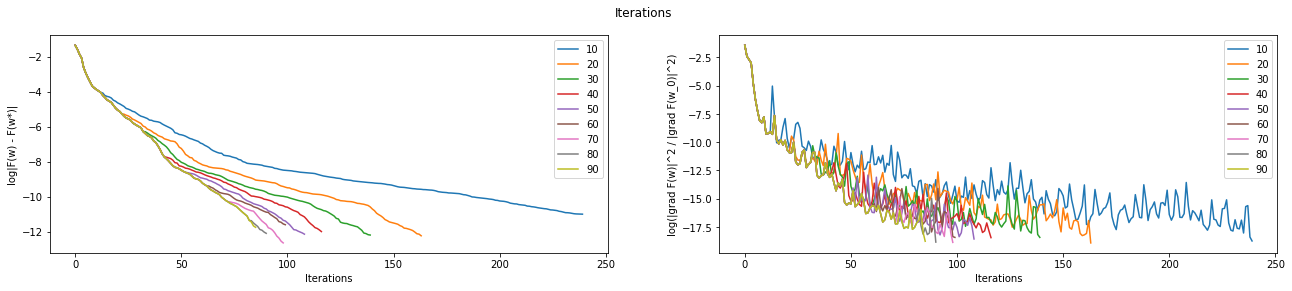

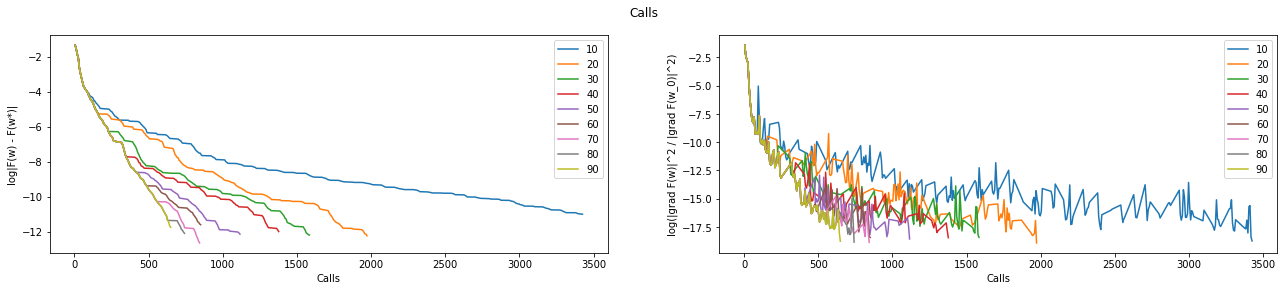

In [47]:
analyze_bfgs('a1a.txt', 'zeros', graph=True, ls=np.arange(10, 100, 10))

## Сравнение

In [48]:
analyze('a1a.txt', hfn_optimize, 'zeros', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297879 |          9 |            850 |   2.74 |
| wolfe    |  0.297909 |          9 |            479 |   2.72 |
| brent    |  0.297879 |          9 |            601 |   2.6  |
| armijo   |  0.297909 |          9 |            479 |   2.75 |


In [49]:
analyze('a1a.txt', optimize_newton, 'zeros', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297875 |         10 |            526 |   1.68 |
| wolfe    |  0.297902 |          7 |             64 |   1.15 |
| brent    |  0.297875 |         10 |            285 |   1.58 |
| armijo   |  0.297902 |          7 |             64 |   1.15 |


In [50]:
analyze('a1a.txt', optimize, 'zeros', nesterov=True, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.298791 |      10000 |         466398 | 127.5  |
| wolfe    |  0.298402 |      10000 |          99437 |  31.3  |
| brent    |  0.298804 |      10000 |         251263 |  71.19 |
| armijo   |  0.298442 |      10000 |         217065 |  64.15 |
| nesterov |  0.298586 |      10000 |         250302 |  75.08 |


In [51]:
analyze_bfgs('a1a.txt', 'zeros', graph=False, ls=np.arange(50, 150, 10))

Dataset shape:  (1605, 119) (1605,)



|   History Size |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------------|-----------|------------|----------------|--------|
|             50 |  0.297881 |        108 |           1116 |   0.46 |
|             60 |  0.297885 |         99 |            851 |   0.36 |
|             70 |  0.297879 |         98 |            844 |   0.38 |
|             80 |  0.297881 |         90 |            742 |   0.33 |
|             90 |  0.297884 |         85 |            649 |   0.29 |
|            100 |  0.297884 |         85 |            649 |   0.3  |
|            110 |  0.297884 |         85 |            649 |   0.29 |
|            120 |  0.297884 |         85 |            649 |   0.3  |
|            130 |  0.297884 |         85 |            649 |   0.29 |
|            140 |  0.297884 |         85 |            649 |   0.3  |


L-BFGS превосходит все остальные методы по скорости сходимости. Но при этом проигрывает по числу итераций и вызовам оракула HF-Newton и Newton. По энтропии методы примерно близки. А градиентный спуск проигрывает по всем параметрам.